In [21]:
import os
import shutil
import subprocess
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import cv2
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

SIZE = 32
VARIETY = False
BATCH_SIZE = 100
AUG_RATIO = 0.20
AUG_DIST = {'A': 0.4, 'B': 0.4, 'C': 0.2}
CV_FOLDS = 3
TUNING_SUBSET_RATIO = 0.20
VARIANCE_TARGETS = [0.80, 0.90, 0.95]
C_VALUES = [10, 100]
GAMMA_VALUES = [0.01, 0.001]
N_ESTIMATORS_VALUES = [100, 200]
MAX_DEPTH_VALUES = [20, 30]
KNN_K_VALUES = [1, 3, 5, 7]
HIST_BINS = 32

print(f"Configuration:")
print(f"  Image size: {SIZE}x{SIZE}")
print(f"  Augmentation ratio: {AUG_RATIO*100}%")
print(f"  Augmentation dist: {AUG_DIST}")
print(f"  CV folds: {CV_FOLDS}")
print(f"  Variance targets: {VARIANCE_TARGETS}")
print(f"  SVM - C values: {C_VALUES}, Gamma values: {GAMMA_VALUES}")
print(f"  RF - N_estimators: {N_ESTIMATORS_VALUES}, Max_depth: {MAX_DEPTH_VALUES}")
print(f"  KNN - K values: {KNN_K_VALUES}")
print(f"  Histogram bins: {HIST_BINS}")
print(f"\n=== STACKING ENSEMBLE ===")
print(f"Level-0: SVM (RBF) + Random Forest + KNN")
print(f"Level-1: Logistic Regression meta-learner")

Configuration:
  Image size: 32x32
  Augmentation ratio: 20.0%
  Augmentation dist: {'A': 0.4, 'B': 0.4, 'C': 0.2}
  CV folds: 3
  Variance targets: [0.8, 0.9, 0.95]
  SVM - C values: [10, 100], Gamma values: [0.01, 0.001]
  RF - N_estimators: [100, 200], Max_depth: [20, 30]
  KNN - K values: [1, 3, 5, 7]
  Histogram bins: 32

=== STACKING ENSEMBLE ===
Level-0: SVM (RBF) + Random Forest + KNN
Level-1: Logistic Regression meta-learner


In [22]:
ROOT_DIR = "dataset/fruit360"
TRAIN_DIR = os.path.join(ROOT_DIR, "Training")
TEST_DIR = os.path.join(ROOT_DIR, "Test")

GITHUB_REPO = "https://github.com/fruits-360/fruits-360-100x100"
CLONE_DIR = "dataset/fruits-360-100x100"

def download_dataset():
    os.makedirs("dataset", exist_ok=True)
    subprocess.run(["git", "clone", GITHUB_REPO, CLONE_DIR], check=True)
    
    os.makedirs(ROOT_DIR, exist_ok=True)
    shutil.move(os.path.join(CLONE_DIR, "Training"), TRAIN_DIR)
    shutil.move(os.path.join(CLONE_DIR, "Test"), TEST_DIR)
    shutil.rmtree(CLONE_DIR, ignore_errors=True)

if not os.path.exists(ROOT_DIR):
    download_dataset()

assert os.path.exists(TRAIN_DIR), f"{TRAIN_DIR} not found"
assert os.path.exists(TEST_DIR), f"{TEST_DIR} not found"
print(f"Dataset ready: {ROOT_DIR}")

Dataset ready: dataset/fruit360


In [23]:
class Fruit360FolderDataset(Dataset):
    def __init__(self, root_dir, transform=None, variety=False):
        self.root_dir = root_dir
        self.transform = transform
        self.variety = variety
        self.samples = []
        
        for class_name in sorted(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            
            label = class_name if self.variety else class_name.split()[0]
            
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith((".jpg", ".png")):
                    self.samples.append((os.path.join(class_dir, img_name), label))
        
        unique_labels = sorted({lbl for _, lbl in self.samples})
        self.label_to_idx = {lbl: i for i, lbl in enumerate(unique_labels)}
        self.idx_to_label = {i: lbl for lbl, i in self.label_to_idx.items()}
        
        print(f"{os.path.basename(root_dir)}: {len(self.samples)} images, {len(unique_labels)} classes")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label_str = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.label_to_idx[label_str]

In [24]:
transform = T.Compose([
    T.Resize((SIZE, SIZE)),
    T.ToTensor(),
])

train_full = Fruit360FolderDataset(TRAIN_DIR, transform=transform, variety=VARIETY)
test_dataset = Fruit360FolderDataset(TEST_DIR, transform=transform, variety=VARIETY)

train_size = int(0.7 * len(train_full))
val_size = len(train_full) - train_size

train_dataset, val_dataset = random_split(
    train_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(RANDOM_STATE)
)

print(f"Train {len(train_dataset)}, Val {len(val_dataset)}, Test {len(test_dataset)}")
print(f"Classes: {len(train_full.label_to_idx)}")

Training: 130344 images, 79 classes
Test: 43442 images, 79 classes
Train 91240, Val 39104, Test 43442
Classes: 79


In [25]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"{len(train_loader)} train batches, {len(val_loader)} val batches, {len(test_loader)} test batches")

913 train batches, 392 val batches, 435 test batches


In [26]:
def extract_numpy(loader):
    X_list, y_list = [], []
    for imgs, labels in loader:
        X_list.append(imgs.numpy())
        y_list.append(labels.numpy())
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

X_train, y_train = extract_numpy(train_loader)
X_val, y_val = extract_numpy(val_loader)
X_test, y_test = extract_numpy(test_loader)

print(f"X_train {X_train.shape}, y_train {y_train.shape}")
print(f"X_val {X_val.shape}, y_val {y_val.shape}")
print(f"X_test {X_test.shape}, y_test {y_test.shape}")

X_train (91240, 3, 32, 32), y_train (91240,)
X_val (39104, 3, 32, 32), y_val (39104,)
X_test (43442, 3, 32, 32), y_test (43442,)


## Augmentation: Scenario Functions

In [27]:
def clamp_01(x):
    return torch.clamp(x, 0.0, 1.0)

def add_color_patches(x, num_patches, color, alpha_range=(0.4, 0.7), size_range=(0.05, 0.15)):
    _, H, W = x.shape
    out = x.clone()
    for _ in range(num_patches):
        s = np.random.uniform(size_range[0], size_range[1])
        patch_area = s * H * W / 4
        r = np.random.uniform(0.5, 1.5)
        patch_h = int(math.sqrt(patch_area / r))
        patch_w = int(math.sqrt(patch_area * r))
        patch_h = max(1, min(H, patch_h))
        patch_w = max(1, min(W, patch_w))
        top = np.random.randint(0, H - patch_h + 1)
        left = np.random.randint(0, W - patch_w + 1)
        bottom = top + patch_h
        right = left + patch_w
        alpha = np.random.uniform(alpha_range[0], alpha_range[1])
        patch = out[:, top:bottom, left:right]
        blended = alpha * color + (1 - alpha) * patch
        out[:, top:bottom, left:right] = blended
    return clamp_01(out)

def add_occlusion_patch(x, area_ratio=0.1, color=torch.tensor([0.5, 0.5, 0.5]).view(3,1,1), alpha=0.5):
    _, H, W = x.shape
    out = x.clone()
    patch_area = area_ratio * H * W
    r = np.random.uniform(0.5, 1.5)
    patch_h = int(math.sqrt(patch_area / r))
    patch_w = int(math.sqrt(patch_area * r))
    patch_h = max(1, min(H, patch_h))
    patch_w = max(1, min(W, patch_w))
    top = np.random.randint(0, H - patch_h + 1)
    left = np.random.randint(0, W - patch_w + 1)
    bottom = top + patch_h
    right = left + patch_w
    patch = out[:, top:bottom, left:right]
    blended = alpha * color + (1 - alpha) * patch
    out[:, top:bottom, left:right] = blended
    return clamp_01(out)

color_dirt = torch.tensor([0.3, 0.25, 0.2]).view(3,1,1)
color_bruise = torch.tensor([0.25, 0.2, 0.15]).view(3,1,1)

def noise_mild(x):
    return clamp_01(x + torch.randn_like(x) * 0.025)

def dark_mild(x):
    return clamp_01(x * 0.65)

def overexposed_mild(x):
    return clamp_01(x * 1.35)

def dirty_mild(x):
    return add_color_patches(x, num_patches=2, color=color_dirt, alpha_range=(0.5, 0.8), size_range=(0.03, 0.08))

def bruised_mild(x):
    return add_color_patches(x, num_patches=1, color=color_bruise, alpha_range=(0.4, 0.7), size_range=(0.03, 0.08))

def occlusion_small(x):
    return add_occlusion_patch(x, area_ratio=0.10, alpha=0.5)

blur_medium = T.GaussianBlur(kernel_size=5, sigma=1.0)

def scenario_A(x):
    x = blur_medium(x)
    x = noise_mild(x)
    if np.random.rand() < 0.7:
        x = dirty_mild(x)
    return x

def scenario_B(x):
    if np.random.rand() < 0.5:
        x = dark_mild(x)
    else:
        x = overexposed_mild(x)
    x = noise_mild(x)
    return x

def scenario_C(x):
    x = occlusion_small(x)
    if np.random.rand() < 0.5:
        x = bruised_mild(x)
    else:
        x = dirty_mild(x)
    return x

scenario_map = {
    'A': scenario_A,
    'B': scenario_B,
    'C': scenario_C,
}

print("Augmentation functions defined")

Augmentation functions defined


## Data Augmentation

In [28]:
np.random.seed(RANDOM_STATE)

n_augment = int(len(X_train) * AUG_RATIO)
aug_indices = np.random.choice(len(X_train), n_augment, replace=False)

scenario_counts = {'A': 0, 'B': 0, 'C': 0}

for aug_idx in aug_indices:
    r = np.random.rand()
    if r < AUG_DIST['A']:
        scenario_name = 'A'
    elif r < AUG_DIST['A'] + AUG_DIST['B']:
        scenario_name = 'B'
    else:
        scenario_name = 'C'
    
    scenario_counts[scenario_name] += 1
    
    img_tensor = torch.from_numpy(X_train[aug_idx]).float()
    aug_img = scenario_map[scenario_name](img_tensor)
    X_train[aug_idx] = aug_img.numpy()

print(f"Augmented {n_augment} images ({AUG_RATIO*100}% of training set)")
print(f"Scenario distribution: {scenario_counts}")
print(f"  A: {scenario_counts['A']/n_augment*100:.1f}%")
print(f"  B: {scenario_counts['B']/n_augment*100:.1f}%")
print(f"  C: {scenario_counts['C']/n_augment*100:.1f}%")

Augmented 18248 images (20.0% of training set)
Scenario distribution: {'A': 7293, 'B': 7358, 'C': 3597}
  A: 40.0%
  B: 40.3%
  C: 19.7%


## Preprocessing: Color Histogram Features and Scaling

In [29]:
def color_hist_features(X, bins=HIST_BINS, img_shape=(3, SIZE, SIZE)):
    n_samples = X.shape[0]
    feats = np.zeros((n_samples, 3 * bins), dtype=np.float32)
    bin_edges = np.linspace(0.0, 1.0, bins + 1)
    for i in range(n_samples):
        img = X[i].reshape(img_shape)
        img = np.transpose(img, (1, 2, 0))
        img = np.clip(img, 0.0, 1.0)
        img_hsv = (img * 255.0).astype(np.uint8)
        img_hsv = cv2.cvtColor(img_hsv, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(img_hsv)
        hists = []
        for channel in (h, s, v):
            ch_norm = channel.astype(np.float32) / 255.0
            hist, _ = np.histogram(ch_norm.ravel(), bins=bin_edges, density=True)
            hists.append(hist)
        feats[i] = np.concatenate(hists)
    return feats

X_train_hist = color_hist_features(X_train, bins=HIST_BINS, img_shape=(3, SIZE, SIZE))
X_val_hist = color_hist_features(X_val, bins=HIST_BINS, img_shape=(3, SIZE, SIZE))
X_test_hist = color_hist_features(X_test, bins=HIST_BINS, img_shape=(3, SIZE, SIZE))

print(f"Histogram features shape: {X_train_hist.shape}")

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_hist)
X_val_sc = scaler.transform(X_val_hist)
X_test_sc = scaler.transform(X_test_hist)

n_classes = len(np.unique(y_train))
print(f"Features per sample: {X_train_hist.shape[1]}")
print(f"Number of classes: {n_classes}")
print("Standardization done")

Histogram features shape: (91240, 96)
Features per sample: 96
Number of classes: 79
Standardization done


## PCA: Variance Analysis & Component Selection

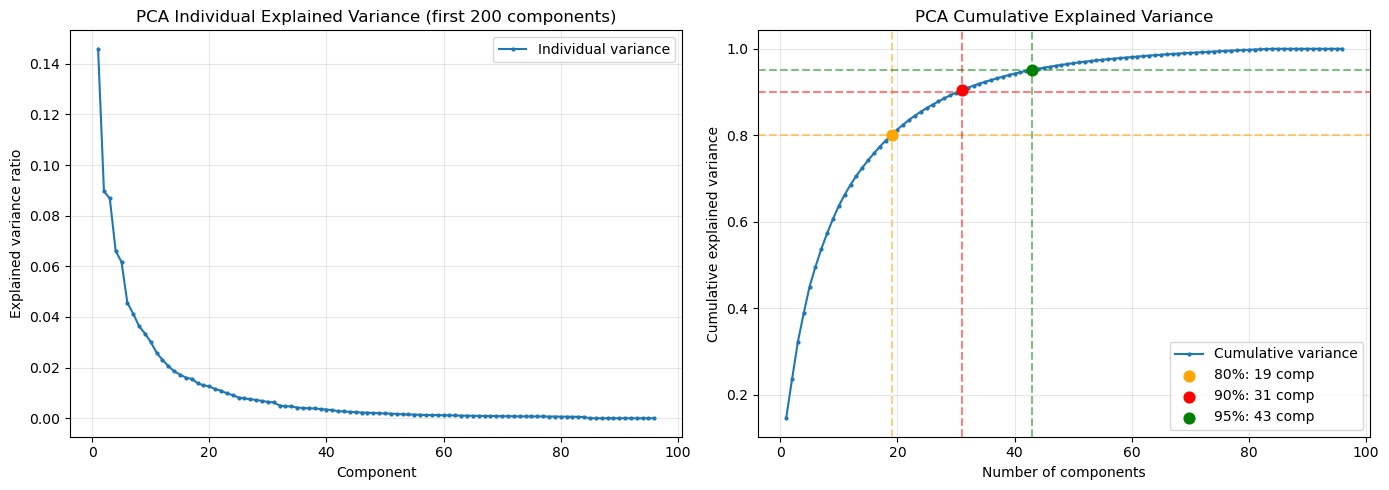

Components needed for each variance target:
  80% variance: 19 components
  90% variance: 31 components
  95% variance: 43 components


In [30]:
pca_full = PCA(n_components=min(X_train_sc.shape), random_state=RANDOM_STATE)
pca_full.fit(X_train_sc)

explained = pca_full.explained_variance_ratio_
cumsum = np.cumsum(explained)

components_for_target = {}
for t in VARIANCE_TARGETS:
    k = np.argmax(cumsum >= t) + 1
    components_for_target[t] = k

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(range(1, min(len(explained) + 1, 200)), explained[:199], marker='o', markersize=2, label='Individual variance')
ax1.set_xlabel('Component')
ax1.set_ylabel('Explained variance ratio')
ax1.set_title('PCA Individual Explained Variance (first 200 components)')
ax1.grid(alpha=0.3)
ax1.legend()

ax2.plot(range(1, len(cumsum) + 1), cumsum, marker='o', markersize=2, label='Cumulative variance')
colors = ['orange', 'red', 'green']
for (t, k), col in zip(components_for_target.items(), colors):
    ax2.axhline(t, color=col, linestyle='--', alpha=0.5)
    ax2.axvline(k, color=col, linestyle='--', alpha=0.5)
    ax2.scatter(k, cumsum[k-1], color=col, s=60, zorder=5, 
                label=f'{int(t*100)}%: {k} comp')

ax2.set_xlabel('Number of components')
ax2.set_ylabel('Cumulative explained variance')
ax2.set_title('PCA Cumulative Explained Variance')
ax2.grid(alpha=0.3)
ax2.legend()
plt.tight_layout()
plt.show()

print("Components needed for each variance target:")
for t, k in components_for_target.items():
    print(f"  {int(t*100)}% variance: {k} components")

## Hyperparameter Tuning: 3-Fold CV on 20% Subset

In [31]:
X_train_sub, _, y_train_sub, _ = train_test_split(
    X_train_sc, y_train,
    train_size=TUNING_SUBSET_RATIO,
    random_state=RANDOM_STATE,
    stratify=y_train,
)

print(f"Using subset of size {len(X_train_sub)} from {len(X_train_sc)} for tuning")

n_components_candidates = [
    components_for_target[t] for t in VARIANCE_TARGETS
]

print("\n" + "="*80)
print("LEVEL-0 BASE MODELS TUNING")
print("="*80)

results = []

print("\n1. SVM Tuning (RBF kernel):")
for n_comp in n_components_candidates:
    pca_temp = PCA(n_components=n_comp, random_state=RANDOM_STATE)
    X_sub_pca = pca_temp.fit_transform(X_train_sub)
    
    for C in C_VALUES:
        for gamma in GAMMA_VALUES:
            svm = SVC(C=C, gamma=gamma, kernel='rbf', random_state=RANDOM_STATE)
            scores = cross_val_score(
                svm, X_sub_pca, y_train_sub,
                cv=CV_FOLDS, scoring='accuracy', n_jobs=-1,
            )
            mean_score = scores.mean()
            results.append({
                'model': 'SVM',
                'n_components': n_comp,
                'param1': C,
                'param2': gamma,
                'cv_accuracy': mean_score,
                'cv_std': scores.std(),
            })
            print(f"  n_comp={n_comp:3d}, C={C:3d}, gamma={gamma:.3f} -> {mean_score:.4f} (+/- {scores.std():.4f})")

svm_tuning = pd.DataFrame([r for r in results if r['model'] == 'SVM']).sort_values('cv_accuracy', ascending=False)
best_svm = svm_tuning.iloc[0]
best_svm_n_comp = int(best_svm['n_components'])
best_svm_C = int(best_svm['param1'])
best_svm_gamma = best_svm['param2']
print(f"  Best SVM: n_comp={best_svm_n_comp}, C={best_svm_C}, gamma={best_svm_gamma:.3f}, acc={best_svm['cv_accuracy']:.4f}")

print("\n2. Random Forest Tuning:")
for n_comp in n_components_candidates:
    pca_temp = PCA(n_components=n_comp, random_state=RANDOM_STATE)
    X_sub_pca = pca_temp.fit_transform(X_train_sub)
    
    for n_est in N_ESTIMATORS_VALUES:
        for max_d in MAX_DEPTH_VALUES:
            rf = RandomForestClassifier(
                n_estimators=n_est,
                max_depth=max_d,
                random_state=RANDOM_STATE,
                n_jobs=-1
            )
            scores = cross_val_score(
                rf, X_sub_pca, y_train_sub,
                cv=CV_FOLDS, scoring='accuracy', n_jobs=-1,
            )
            mean_score = scores.mean()
            results.append({
                'model': 'RF',
                'n_components': n_comp,
                'param1': n_est,
                'param2': max_d,
                'cv_accuracy': mean_score,
                'cv_std': scores.std(),
            })
            print(f"  n_comp={n_comp:3d}, n_est={n_est:3d}, max_d={max_d:2d} -> {mean_score:.4f} (+/- {scores.std():.4f})")

rf_tuning = pd.DataFrame([r for r in results if r['model'] == 'RF']).sort_values('cv_accuracy', ascending=False)
best_rf = rf_tuning.iloc[0]
best_rf_n_comp = int(best_rf['n_components'])
best_rf_n_est = int(best_rf['param1'])
best_rf_max_d = int(best_rf['param2'])
print(f"  Best RF: n_comp={best_rf_n_comp}, n_est={best_rf_n_est}, max_d={best_rf_max_d}, acc={best_rf['cv_accuracy']:.4f}")

print("\n3. KNN Tuning:")
for n_comp in n_components_candidates:
    pca_temp = PCA(n_components=n_comp, random_state=RANDOM_STATE)
    X_sub_pca = pca_temp.fit_transform(X_train_sub)
    
    for k in KNN_K_VALUES:
        knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
        scores = cross_val_score(
            knn, X_sub_pca, y_train_sub,
            cv=CV_FOLDS, scoring='accuracy', n_jobs=-1,
        )
        mean_score = scores.mean()
        results.append({
            'model': 'KNN',
            'n_components': n_comp,
            'param1': k,
            'param2': None,
            'cv_accuracy': mean_score,
            'cv_std': scores.std(),
        })
        print(f"  n_comp={n_comp:3d}, k={k} -> {mean_score:.4f} (+/- {scores.std():.4f})")

knn_tuning = pd.DataFrame([r for r in results if r['model'] == 'KNN']).sort_values('cv_accuracy', ascending=False)
best_knn = knn_tuning.iloc[0]
best_knn_n_comp = int(best_knn['n_components'])
best_knn_k = int(best_knn['param1'])
print(f"  Best KNN: n_comp={best_knn_n_comp}, k={best_knn_k}, acc={best_knn['cv_accuracy']:.4f}")

print("\n" + "="*80)
print("Level-0 Best Configurations Summary:")
print("="*80)
print(f"SVM:  n_comp={best_svm_n_comp}, C={best_svm_C}, gamma={best_svm_gamma:.3f} -> {best_svm['cv_accuracy']:.4f}")
print(f"RF:   n_comp={best_rf_n_comp}, n_est={best_rf_n_est}, max_d={best_rf_max_d} -> {best_rf['cv_accuracy']:.4f}")
print(f"KNN:  n_comp={best_knn_n_comp}, k={best_knn_k} -> {best_knn['cv_accuracy']:.4f}")

Using subset of size 18248 from 91240 for tuning

LEVEL-0 BASE MODELS TUNING

1. SVM Tuning (RBF kernel):
  n_comp= 19, C= 10, gamma=0.010 -> 0.9430 (+/- 0.0025)
  n_comp= 19, C= 10, gamma=0.001 -> 0.7921 (+/- 0.0076)
  n_comp= 19, C=100, gamma=0.010 -> 0.9613 (+/- 0.0050)
  n_comp= 19, C=100, gamma=0.001 -> 0.9014 (+/- 0.0035)
  n_comp= 31, C= 10, gamma=0.010 -> 0.9580 (+/- 0.0023)
  n_comp= 31, C= 10, gamma=0.001 -> 0.8453 (+/- 0.0063)
  n_comp= 31, C=100, gamma=0.010 -> 0.9663 (+/- 0.0028)
  n_comp= 31, C=100, gamma=0.001 -> 0.9282 (+/- 0.0030)
  n_comp= 43, C= 10, gamma=0.010 -> 0.9601 (+/- 0.0029)
  n_comp= 43, C= 10, gamma=0.001 -> 0.8679 (+/- 0.0078)
  n_comp= 43, C=100, gamma=0.010 -> 0.9666 (+/- 0.0026)
  n_comp= 43, C=100, gamma=0.001 -> 0.9338 (+/- 0.0040)
  Best SVM: n_comp=43, C=100, gamma=0.010, acc=0.9666

2. Random Forest Tuning:
  n_comp= 19, n_est=100, max_d=20 -> 0.9272 (+/- 0.0046)
  n_comp= 19, n_est=100, max_d=30 -> 0.9336 (+/- 0.0047)
  n_comp= 19, n_est=200, max

## Final Model Training on Full Augmented Training Set

In [32]:
print("\n" + "="*80)
print("LEVEL-1 META-LEARNER TRAINING")
print("="*80)

n_classes = len(np.unique(y_train))

print(f"\nFinal PCA components:")
print(f"  SVM: {best_svm_n_comp}")
print(f"  RF:  {best_rf_n_comp}")
print(f"  KNN: {best_knn_n_comp}")

pca_svm_final = PCA(n_components=best_svm_n_comp, random_state=RANDOM_STATE)
X_train_svm = pca_svm_final.fit_transform(X_train_sc)

pca_rf_final = PCA(n_components=best_rf_n_comp, random_state=RANDOM_STATE)
X_train_rf = pca_rf_final.fit_transform(X_train_sc)

pca_knn_final = PCA(n_components=best_knn_n_comp, random_state=RANDOM_STATE)
X_train_knn = pca_knn_final.fit_transform(X_train_sc)

print("\nGenerating Level-0 meta-features via Stratified K-Fold cross-validation...")
print("(This prevents data leakage - each fold uses unseen data)")

def align_proba(model, X, n_classes):
    proba = model.predict_proba(X)
    if proba.shape[1] == n_classes:
        return proba
    aligned = np.zeros((proba.shape[0], n_classes), dtype=proba.dtype)
    aligned[:, model.classes_.astype(int)] = proba
    return aligned

skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
meta_features_train = np.zeros((len(X_train_sc), n_classes * 3), dtype=np.float32)

fold_idx = 0
for train_idx, val_idx in skf.split(X_train_sc, y_train):
    fold_idx += 1
    print(f"\nFold {fold_idx}/{CV_FOLDS}:")
    
    X_fold_train_sc = X_train_sc[train_idx]
    X_fold_val_sc = X_train_sc[val_idx]
    y_fold_train = y_train[train_idx]
    y_fold_val = y_train[val_idx]
    
    pca_svm_fold = PCA(n_components=best_svm_n_comp, random_state=RANDOM_STATE)
    X_fold_train_svm = pca_svm_fold.fit_transform(X_fold_train_sc)
    X_fold_val_svm = pca_svm_fold.transform(X_fold_val_sc)
    
    pca_rf_fold = PCA(n_components=best_rf_n_comp, random_state=RANDOM_STATE)
    X_fold_train_rf = pca_rf_fold.fit_transform(X_fold_train_sc)
    X_fold_val_rf = pca_rf_fold.transform(X_fold_val_sc)
    
    pca_knn_fold = PCA(n_components=best_knn_n_comp, random_state=RANDOM_STATE)
    X_fold_train_knn = pca_knn_fold.fit_transform(X_fold_train_sc)
    X_fold_val_knn = pca_knn_fold.transform(X_fold_val_sc)
    
    svm_fold = SVC(C=best_svm_C, gamma=best_svm_gamma, kernel='rbf', random_state=RANDOM_STATE, probability=True)
    svm_fold.fit(X_fold_train_svm, y_fold_train)
    proba_svm = align_proba(svm_fold, X_fold_val_svm, n_classes)
    preds_svm = np.argmax(proba_svm, axis=1)
    print(f"  SVM fold accuracy: {accuracy_score(y_fold_val, preds_svm):.4f}")
    
    rf_fold = RandomForestClassifier(
        n_estimators=best_rf_n_est,
        max_depth=best_rf_max_d,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    rf_fold.fit(X_fold_train_rf, y_fold_train)
    proba_rf = align_proba(rf_fold, X_fold_val_rf, n_classes)
    preds_rf = np.argmax(proba_rf, axis=1)
    print(f"  RF fold accuracy: {accuracy_score(y_fold_val, preds_rf):.4f}")
    
    knn_fold = KNeighborsClassifier(n_neighbors=best_knn_k, weights='distance')
    knn_fold.fit(X_fold_train_knn, y_fold_train)
    proba_knn = align_proba(knn_fold, X_fold_val_knn, n_classes)
    preds_knn = np.argmax(proba_knn, axis=1)
    print(f"  KNN fold accuracy: {accuracy_score(y_fold_val, preds_knn):.4f}")
    
    meta_features_train[val_idx] = np.hstack([proba_svm, proba_rf, proba_knn])

print(f"\nMeta-features shape: {meta_features_train.shape}")
print(f"Sample meta-features (first row, first 10 values):\n{meta_features_train[0][:10]}")

print("\nTraining final Level-0 base models on full training set...")
svm_final = SVC(C=best_svm_C, gamma=best_svm_gamma, kernel='rbf', random_state=RANDOM_STATE, probability=True)
svm_final.fit(X_train_svm, y_train)
print("  SVM trained")

rf_final = RandomForestClassifier(
    n_estimators=best_rf_n_est,
    max_depth=best_rf_max_d,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_final.fit(X_train_rf, y_train)
print("  RF trained")

knn_final = KNeighborsClassifier(n_neighbors=best_knn_k, weights='distance')
knn_final.fit(X_train_knn, y_train)
print("  KNN trained")

print("\nTraining Level-1 meta-learner (Logistic Regression)...")
meta_learner = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE, multi_class='multinomial')
meta_learner.fit(meta_features_train, y_train)
print("Meta-learner trained")

print("\n" + "="*80)
print("All models ready for evaluation")


LEVEL-1 META-LEARNER TRAINING

Final PCA components:
  SVM: 43
  RF:  19
  KNN: 43

Generating Level-0 meta-features via Stratified K-Fold cross-validation...
(This prevents data leakage - each fold uses unseen data)

Fold 1/3:
  SVM fold accuracy: 0.9916
  RF fold accuracy: 0.9782
  KNN fold accuracy: 0.9890

Fold 2/3:
  SVM fold accuracy: 0.9910
  RF fold accuracy: 0.9794
  KNN fold accuracy: 0.9894

Fold 3/3:
  SVM fold accuracy: 0.9919
  RF fold accuracy: 0.9781
  KNN fold accuracy: 0.9874

Meta-features shape: (91240, 237)
Sample meta-features (first row, first 10 values):
[8.6746120e-05 1.7048018e-04 1.2964220e-04 2.6868674e-04 2.7562448e-04
 1.0939392e-04 8.2300947e-05 9.7272066e-05 1.5871266e-04 8.7319015e-05]

Training final Level-0 base models on full training set...
  SVM trained
  RF trained
  KNN trained

Training Level-1 meta-learner (Logistic Regression)...


/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Meta-learner trained

All models ready for evaluation


## Validation Performance

In [33]:
X_val_svm = pca_svm_final.transform(X_val_sc)
X_val_rf = pca_rf_final.transform(X_val_sc)
X_val_knn = pca_knn_final.transform(X_val_sc)

val_proba_svm = align_proba(svm_final, X_val_svm, n_classes)
val_proba_rf = align_proba(rf_final, X_val_rf, n_classes)
val_proba_knn = align_proba(knn_final, X_val_knn, n_classes)

val_meta_features = np.hstack([val_proba_svm, val_proba_rf, val_proba_knn])

y_val_pred = meta_learner.predict(val_meta_features)
val_acc = accuracy_score(y_val, y_val_pred)

print(f"Validation accuracy (stacked): {val_acc:.4f}")

val_pred_svm = np.argmax(val_proba_svm, axis=1)
val_pred_rf = np.argmax(val_proba_rf, axis=1)
val_pred_knn = np.argmax(val_proba_knn, axis=1)

val_acc_svm = accuracy_score(y_val, val_pred_svm)
val_acc_rf = accuracy_score(y_val, val_pred_rf)
val_acc_knn = accuracy_score(y_val, val_pred_knn)
print(f"  Individual components - SVM: {val_acc_svm:.4f}, RF: {val_acc_rf:.4f}, KNN: {val_acc_knn:.4f}")

Validation accuracy (stacked): 1.0000
  Individual components - SVM: 1.0000, RF: 0.9992, KNN: 0.9999


## Test on Clean Data

In [34]:
X_test_svm = pca_svm_final.transform(X_test_sc)
X_test_rf = pca_rf_final.transform(X_test_sc)
X_test_knn = pca_knn_final.transform(X_test_sc)

test_proba_svm = align_proba(svm_final, X_test_svm, n_classes)
test_proba_rf = align_proba(rf_final, X_test_rf, n_classes)
test_proba_knn = align_proba(knn_final, X_test_knn, n_classes)

test_meta_features = np.hstack([test_proba_svm, test_proba_rf, test_proba_knn])

y_test_pred = meta_learner.predict(test_meta_features)
test_acc_clean = accuracy_score(y_test, y_test_pred)

print(f"Test accuracy (clean, stacked): {test_acc_clean:.4f}")

test_pred_svm = np.argmax(test_proba_svm, axis=1)
test_pred_rf = np.argmax(test_proba_rf, axis=1)
test_pred_knn = np.argmax(test_proba_knn, axis=1)

test_acc_svm = accuracy_score(y_test, test_pred_svm)
test_acc_rf = accuracy_score(y_test, test_pred_rf)
test_acc_knn = accuracy_score(y_test, test_pred_knn)
print(f"  Individual components - SVM: {test_acc_svm:.4f}, RF: {test_acc_rf:.4f}, KNN: {test_acc_knn:.4f}")

Test accuracy (clean, stacked): 0.9887
  Individual components - SVM: 0.9881, RF: 0.9752, KNN: 0.9871


## Test on Realistic Degraded Dataset (Mixed Scenarios)

In [35]:
scenarios_mixed = {
    "clean": lambda x: x,
    "scenario_A": scenario_A,
    "scenario_B": scenario_B,
    "scenario_C": scenario_C,
}

def evaluate_mixed_scenarios(test_loader, scenario_fns, probs, verbose=True):
    np.random.seed(RANDOM_STATE)
    torch.manual_seed(RANDOM_STATE)
    
    scenario_names = list(scenario_fns.keys())
    all_preds = []
    all_labels = []
    all_preds_svm = []
    all_preds_rf = []
    all_preds_knn = []
    scenario_counts = {name: 0 for name in scenario_names}
    
    start = time.time()
    
    for imgs, labels in test_loader:
        imgs_batch = []
        for img in imgs:
            r = np.random.rand()
            if r < probs[0]:
                scenario = scenario_names[0]
            elif r < probs[0] + probs[1]:
                scenario = scenario_names[1]
            elif r < probs[0] + probs[1] + probs[2]:
                scenario = scenario_names[2]
            else:
                scenario = scenario_names[3]
            
            scenario_counts[scenario] += 1
            x = scenario_fns[scenario](img)
            imgs_batch.append(x.unsqueeze(0))
        
        imgs_batch = torch.cat(imgs_batch, dim=0)
        X = imgs_batch.numpy()
        X_hist = color_hist_features(X, bins=HIST_BINS, img_shape=(3, SIZE, SIZE))
        X_hist = scaler.transform(X_hist)
        
        X_svm = pca_svm_final.transform(X_hist)
        X_rf = pca_rf_final.transform(X_hist)
        X_knn = pca_knn_final.transform(X_hist)
        
        proba_svm = align_proba(svm_final, X_svm, n_classes)
        proba_rf = align_proba(rf_final, X_rf, n_classes)
        proba_knn = align_proba(knn_final, X_knn, n_classes)
        
        meta_features_batch = np.hstack([proba_svm, proba_rf, proba_knn])
        preds_stacked = meta_learner.predict(meta_features_batch)
        
        preds_svm = np.argmax(proba_svm, axis=1)
        preds_rf = np.argmax(proba_rf, axis=1)
        preds_knn = np.argmax(proba_knn, axis=1)
        
        all_preds.extend(preds_stacked)
        all_preds_svm.extend(preds_svm)
        all_preds_rf.extend(preds_rf)
        all_preds_knn.extend(preds_knn)
        all_labels.extend(labels.numpy())
    
    all_preds = np.array(all_preds)
    all_preds_svm = np.array(all_preds_svm)
    all_preds_rf = np.array(all_preds_rf)
    all_preds_knn = np.array(all_preds_knn)
    all_labels = np.array(all_labels)
    
    acc = (all_preds == all_labels).mean()
    acc_svm = (all_preds_svm == all_labels).mean()
    acc_rf = (all_preds_rf == all_labels).mean()
    acc_knn = (all_preds_knn == all_labels).mean()
    elapsed = time.time() - start
    
    if verbose:
        print(f"\nAccuracy on mixed realistic distribution (STACKED): {acc:.4f}")
        print(f"  Individual - SVM: {acc_svm:.4f}, RF: {acc_rf:.4f}, KNN: {acc_knn:.4f}")
        print(f"Time: {elapsed:.2f}s")
        print(f"Scenario distribution (actual): {scenario_counts}")
    
    return acc, elapsed, scenario_counts, all_labels, all_preds, (acc_svm, acc_rf, acc_knn)

probs_distribution = [0.60, 0.15, 0.15, 0.10]

acc_mixed, time_mixed, counts_mixed, y_true_mixed, y_pred_mixed, (acc_svm_mixed, acc_rf_mixed, acc_knn_mixed) = evaluate_mixed_scenarios(
    test_loader,
    scenarios_mixed,
    probs_distribution,
    verbose=True,
)


Accuracy on mixed realistic distribution (STACKED): 0.9724
  Individual - SVM: 0.9718, RF: 0.9377, KNN: 0.9649
Time: 224.29s
Scenario distribution (actual): {'clean': 26070, 'scenario_A': 6650, 'scenario_B': 6421, 'scenario_C': 4301}


## Additional Test: Alternative Distribution (50/20/20/10)

In [36]:
probs_distribution_alt = [0.50, 0.20, 0.20, 0.10]

print("Testing with alternative distribution (50% clean / 20% A / 20% B / 10% C)...")
acc_mixed_alt, time_mixed_alt, counts_mixed_alt, y_true_mixed_alt, y_pred_mixed_alt, (acc_svm_alt, acc_rf_alt, acc_knn_alt) = evaluate_mixed_scenarios(
    test_loader,
    scenarios_mixed,
    probs_distribution_alt,
    verbose=True,
)

print(f"\nComparison (Stacked):")
print(f"  Standard (60/15/15/10): {acc_mixed:.4f}")
print(f"  Alternative (50/20/20/10): {acc_mixed_alt:.4f}")
print(f"  Difference: {(acc_mixed_alt - acc_mixed):.4f}")

Testing with alternative distribution (50% clean / 20% A / 20% B / 10% C)...

Accuracy on mixed realistic distribution (STACKED): 0.9666
  Individual - SVM: 0.9671, RF: 0.9291, KNN: 0.9574
Time: 229.05s
Scenario distribution (actual): {'clean': 21927, 'scenario_A': 8659, 'scenario_B': 8570, 'scenario_C': 4286}

Comparison (Stacked):
  Standard (60/15/15/10): 0.9724
  Alternative (50/20/20/10): 0.9666
  Difference: -0.0058


## Results Summary

In [37]:
results_summary = {
    'Model': 'Stacking Ensemble (SVM + RF + KNN)',
    'Image Size': f'{SIZE}x{SIZE}',
    'Augmentation': f'{AUG_RATIO*100}% (A: {AUG_DIST["A"]*100:.0f}%, B: {AUG_DIST["B"]*100:.0f}%, C: {AUG_DIST["C"]*100:.0f}%)',
    'PCA comps (SVM/RF/KNN)': f'{best_svm_n_comp}/{best_rf_n_comp}/{best_knn_n_comp}',
    'Level-1 Meta-Learner': 'Logistic Regression',
    'Val Accuracy (Stacked)': f'{val_acc:.4f}',
    'Test Accuracy Clean (Stacked)': f'{test_acc_clean:.4f}',
    'Test Accuracy (60/15/15/10)': f'{acc_mixed:.4f}',
    'Test Accuracy (50/20/20/10)': f'{acc_mixed_alt:.4f}',
}

print("\n" + "="*60)
print("FINAL RESULTS SUMMARY - STACKING ENSEMBLE")
print("="*60)
for key, val in results_summary.items():
    print(f"{key:.<40} {val}")
print("="*60)

print("\n" + "="*60)
print("DETAILED COMPARISON: STACKED vs INDIVIDUAL BASE MODELS")
print("="*60)

comparison_data = {
    'Distribution': ['Clean (Validation)', 'Clean (Test)', '60/15/15/10', '50/20/20/10'],
    'Stacked': [f'{val_acc:.4f}', f'{test_acc_clean:.4f}', f'{acc_mixed:.4f}', f'{acc_mixed_alt:.4f}'],
    'SVM': [f'{val_acc_svm:.4f}', f'{test_acc_svm:.4f}', f'{acc_svm_mixed:.4f}', f'{acc_svm_alt:.4f}'],
    'RF': [f'{val_acc_rf:.4f}', f'{test_acc_rf:.4f}', f'{acc_rf_mixed:.4f}', f'{acc_rf_alt:.4f}'],
    'KNN': [f'{val_acc_knn:.4f}', f'{test_acc_knn:.4f}', f'{acc_knn_mixed:.4f}', f'{acc_knn_alt:.4f}'],
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n" + "="*60)
print("IMPROVEMENT OVER BEST INDIVIDUAL MODEL (SVM)")
print("="*60)
print(f"Clean (Validation):  {(val_acc - val_acc_svm):+.4f}")
print(f"Clean (Test):        {(test_acc_clean - test_acc_svm):+.4f}")
print(f"60/15/15/10:         {(acc_mixed - acc_svm_mixed):+.4f}")
print(f"50/20/20/10:         {(acc_mixed_alt - acc_svm_alt):+.4f}")


FINAL RESULTS SUMMARY - STACKING ENSEMBLE
Model................................... Stacking Ensemble (SVM + RF + KNN)
Image Size.............................. 32x32
Augmentation............................ 20.0% (A: 40%, B: 40%, C: 20%)
PCA comps (SVM/RF/KNN).................. 43/19/43
Level-1 Meta-Learner.................... Logistic Regression
Val Accuracy (Stacked).................. 1.0000
Test Accuracy Clean (Stacked)........... 0.9887
Test Accuracy (60/15/15/10)............. 0.9724
Test Accuracy (50/20/20/10)............. 0.9666

DETAILED COMPARISON: STACKED vs INDIVIDUAL BASE MODELS
      Distribution Stacked    SVM     RF    KNN
Clean (Validation)  1.0000 1.0000 0.9992 0.9999
      Clean (Test)  0.9887 0.9881 0.9752 0.9871
       60/15/15/10  0.9724 0.9718 0.9377 0.9649
       50/20/20/10  0.9666 0.9671 0.9291 0.9574

IMPROVEMENT OVER BEST INDIVIDUAL MODEL (SVM)
Clean (Validation):  +0.0000
Clean (Test):        +0.0006
60/15/15/10:         +0.0006
50/20/20/10:         -0.0005


## Save Models

In [38]:
os.makedirs("saved_models", exist_ok=True)

suffix = "_augmented_colorhist32bins_32x32_stacking"

joblib.dump(scaler, f"saved_models/scaler{suffix}.joblib")
joblib.dump(pca_svm_final, f"saved_models/pca_svm{suffix}.joblib")
joblib.dump(pca_rf_final, f"saved_models/pca_rf{suffix}.joblib")
joblib.dump(pca_knn_final, f"saved_models/pca_knn{suffix}.joblib")
joblib.dump(svm_final, f"saved_models/svm{suffix}.joblib")
joblib.dump(rf_final, f"saved_models/rf{suffix}.joblib")
joblib.dump(knn_final, f"saved_models/knn{suffix}.joblib")
joblib.dump(meta_learner, f"saved_models/meta_learner{suffix}.joblib")

print(f"Models saved to saved_models/:")
print(f"  - scaler{suffix}.joblib")
print(f"  - pca_svm{suffix}.joblib")
print(f"  - pca_rf{suffix}.joblib")
print(f"  - pca_knn{suffix}.joblib")
print(f"  - svm{suffix}.joblib")
print(f"  - rf{suffix}.joblib")
print(f"  - knn{suffix}.joblib")
print(f"  - meta_learner{suffix}.joblib")

Models saved to saved_models/:
  - scaler_augmented_colorhist32bins_32x32_stacking.joblib
  - pca_svm_augmented_colorhist32bins_32x32_stacking.joblib
  - pca_rf_augmented_colorhist32bins_32x32_stacking.joblib
  - pca_knn_augmented_colorhist32bins_32x32_stacking.joblib
  - svm_augmented_colorhist32bins_32x32_stacking.joblib
  - rf_augmented_colorhist32bins_32x32_stacking.joblib
  - knn_augmented_colorhist32bins_32x32_stacking.joblib
  - meta_learner_augmented_colorhist32bins_32x32_stacking.joblib


## Classification Report

In [39]:
idx_to_label = test_dataset.idx_to_label
target_names = [idx_to_label[i] for i in range(len(idx_to_label))]

print("=" * 60)
print("Classification Report - Standard Distribution (60/15/15/10)")
print("=" * 60)
print(classification_report(y_true_mixed, y_pred_mixed, target_names=target_names, digits=3))

print("\n" + "=" * 60)
print("Classification Report - Alternative Distribution (50/20/20/10)")
print("=" * 60)
print(classification_report(y_true_mixed_alt, y_pred_mixed_alt, target_names=target_names, digits=3))

Classification Report - Standard Distribution (60/15/15/10)
              precision    recall  f1-score   support

     Almonds      1.000     0.922     0.959        77
       Apple      0.935     0.979     0.957      5506
     Apricot      0.994     0.963     0.978       164
     Avocado      0.981     0.985     0.983      1017
      Banana      0.948     0.983     0.965       645
       Beans      0.951     1.000     0.975        77
    Beetroot      0.943     0.667     0.781       150
  BlackBerry      1.000     0.993     0.997       145
 Blackberrie      0.991     0.972     0.981       600
   Blueberry      1.000     1.000     1.000       154
     Cabbage      1.000     1.000     1.000        96
      Cactus      0.939     0.989     0.963       634
        Caju      0.947     0.947     0.947        75
  Cantaloupe      0.992     0.996     0.994       484
   Carambula      0.993     0.904     0.946       166
      Carrot      1.000     1.000     1.000        50
 Cauliflower      0.9

## Confusion Matrices

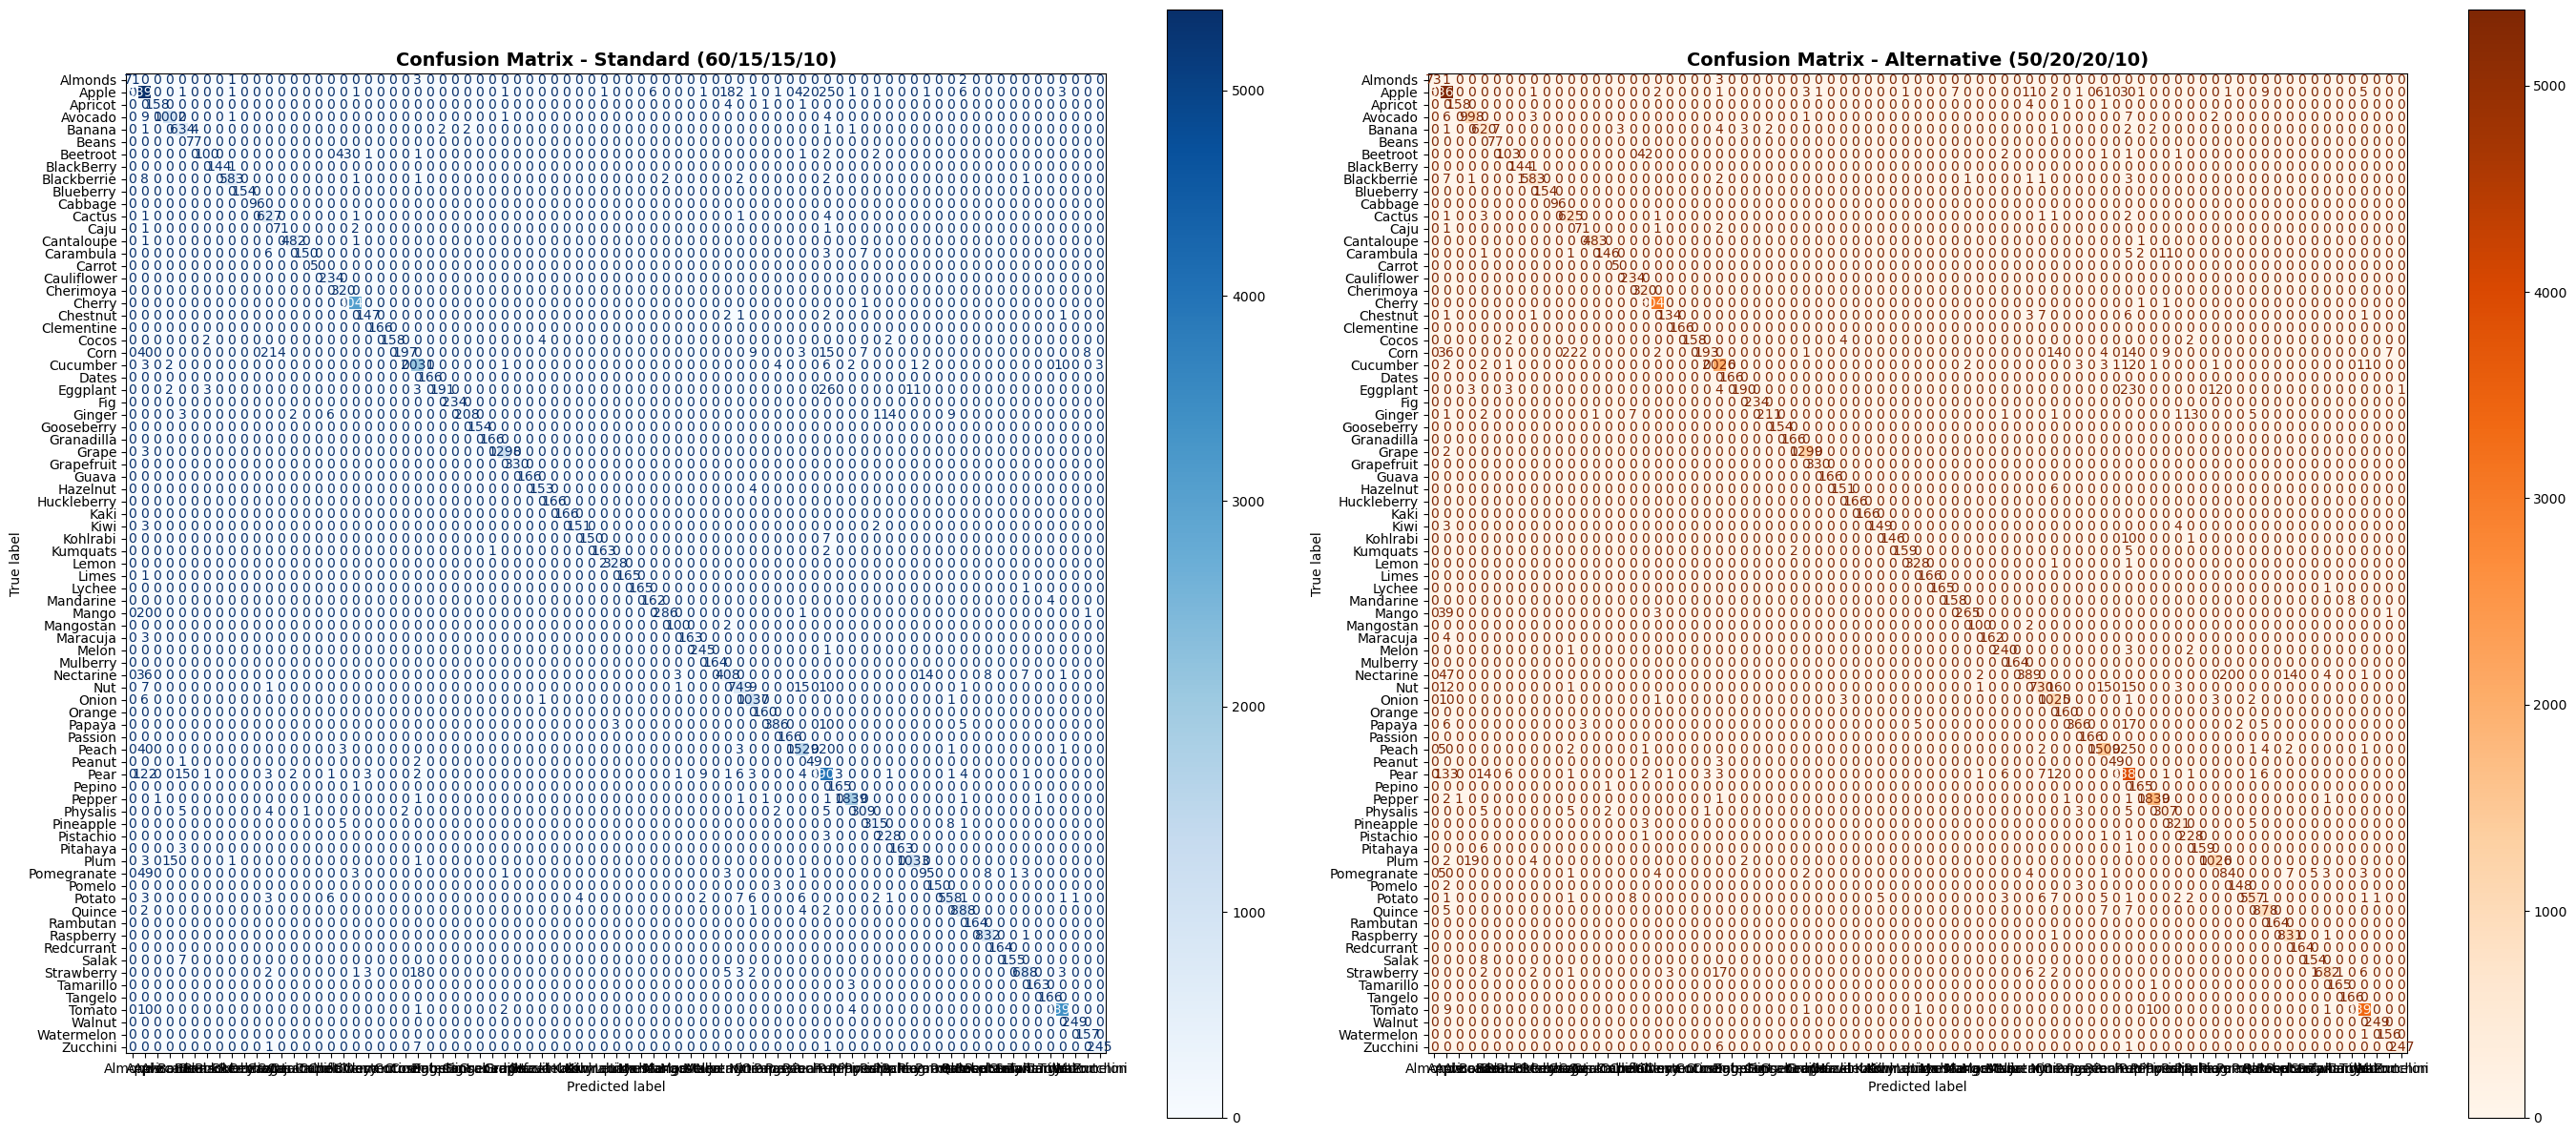


Confusion Matrix Summary:
Standard (60/15/15/10) - Correct predictions: 42242 / 43442
Alternative (50/20/20/10) - Correct predictions: 41991 / 43442


In [40]:
fig, axes = plt.subplots(1, 2, figsize=(28, 12))

cm_standard = confusion_matrix(y_true_mixed, y_pred_mixed)
disp_standard = ConfusionMatrixDisplay(confusion_matrix=cm_standard, display_labels=target_names)
disp_standard.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix - Standard (60/15/15/10)', fontsize=14, fontweight='bold')

cm_alt = confusion_matrix(y_true_mixed_alt, y_pred_mixed_alt)
disp_alt = ConfusionMatrixDisplay(confusion_matrix=cm_alt, display_labels=target_names)
disp_alt.plot(ax=axes[1], cmap='Oranges')
axes[1].set_title('Confusion Matrix - Alternative (50/20/20/10)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nConfusion Matrix Summary:")
print(f"Standard (60/15/15/10) - Correct predictions: {np.trace(cm_standard)} / {cm_standard.sum()}")
print(f"Alternative (50/20/20/10) - Correct predictions: {np.trace(cm_alt)} / {cm_alt.sum()}")